In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random
import seaborn as sns
sns.set()

Instructions for updating:
non-resource variables are not supported in the long term


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Using dataset from txt file
data = pd.read_csv('aapl.us.txt')
data

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0
...,...,...,...,...,...,...,...
8359,2017-11-06,171.75000,174.36000,171.10000,173.63000,34901241,0
8360,2017-11-07,173.29000,174.51000,173.29000,174.18000,24424877,0
8361,2017-11-08,174.03000,175.61000,173.71000,175.61000,24451166,0
8362,2017-11-09,174.48000,175.46000,172.52000,175.25000,29533086,0


In [3]:
def get_index(date):
  for no, i in enumerate(data.Date):
    if i == date:
      index = no
  return index

In [4]:
# get index from training and testing period
train_start_index = get_index('2015-01-02')
train_end_index = get_index('2016-12-30')
test_start_index = get_index('2017-01-03')
test_end_index = get_index('2017-11-10')

train_set = data[train_start_index:train_end_index + 1]
test_set = data[test_start_index:test_end_index + 1]

In [5]:
print("Training sample size: ", len(train_set))
print("Testing sample size: ", len(test_set))

Training sample size:  504
Testing sample size:  218


In [6]:
class Agent:

    LEARNING_RATE = 1e-5
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.999
    MIN_EPSILON = 0.01
    GAMMA = 0.95
    MEMORIES = deque()
    MEMORY_SIZE = 1000
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.X = tf.placeholder(tf.float32, (None, None, self.state_size))
        self.Y = tf.placeholder(tf.float32, (None, self.OUTPUT_SIZE))
        cell = tf.nn.rnn_cell.LSTMCell(self.LAYER_SIZE, state_is_tuple = False)
        self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * self.LAYER_SIZE))
        self.rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
        self.logits = tf.layers.dense(self.rnn[:,-1], self.OUTPUT_SIZE)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _memorize(self, state, action, reward, new_state, dead, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, dead, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        Q = self.sess.run(self.logits, feed_dict={self.X:states, self.hidden_layer:init_values})
        Q_new = self.sess.run(self.logits, feed_dict={self.X:new_states, self.hidden_layer:init_values})
        replay_size = len(replay)
        X = np.empty((replay_size, 4, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        INIT_VAL = np.empty((replay_size, 2 * self.LAYER_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, dead_r, rnn_memory = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not dead_r:
                target[action_r] += self.GAMMA * np.amax(Q_new[i])
            X[i] = state_r
            Y[i] = target
            INIT_VAL[i] = rnn_memory
        return X, Y, INIT_VAL
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        profit_loss = []
        state = self.get_state(0)
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):
            action, last_state = self.sess.run([self.logits,self.last_state],
                                                feed_dict={self.X:[self.INITIAL_FEATURES],
                                                            self.hidden_layer:init_value})
            action, init_value = np.argmax(action[0]), last_state
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((test_close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, test_close[t], invest, initial_money)
                )
            
            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
            total_gains = initial_money - starting_money
            profit_loss.append(total_gains)
        invest = ((initial_money - starting_money) / starting_money) * 100
        return states_buy, states_sell, total_gains, invest, profit_loss
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.logits,
                                                  self.last_state],
                                                  feed_dict={self.X:[self.INITIAL_FEATURES],
                                                             self.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state
                    
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state, 
                               starting_money < initial_money, init_value[0])
                self.INITIAL_FEATURES = new_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y, INIT_VAL = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.cost, self.optimizer], 
                                        feed_dict={self.X: X, self.Y:Y,
                                                  self.hidden_layer: INIT_VAL})
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
                
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [13]:
train_close = train_set.Close.values.tolist()
initial_money = 10000
window_size = 100
skip = 1
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = train_close, 
              skip = skip)
agent.train(iterations = 500, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: -46.031000.3, cost: 0.003801, total money: 9953.969000
epoch: 20, total rewards: -53.045000.3, cost: 0.001471, total money: 9946.955000
epoch: 30, total rewards: -43.839000.3, cost: 0.001638, total money: 9956.161000
epoch: 40, total rewards: -39.918000.3, cost: 0.002146, total money: 9960.082000
epoch: 50, total rewards: 5.060000.3, cost: 0.005141, total money: 10005.060000
epoch: 60, total rewards: 10.953000.3, cost: 0.001808, total money: 10010.953000
epoch: 70, total rewards: -1.011000.3, cost: 0.001098, total money: 9998.989000
epoch: 80, total rewards: -11.135000.3, cost: 0.005250, total money: 9873.975000
epoch: 90, total rewards: -31.218000.3, cost: 0.000300, total money: 9853.892000
epoch: 100, total rewards: -0.310000.3, cost: 0.001959, total money: 9769.390000
epoch: 110, total rewards: -21.634000.3, cost: 0.001362, total money: 9863.476000
epoch: 120, total rewards: -50.292000.3, cost: 0.002022, total money: 9834.818000
epoch: 130, total rewards: -

In [14]:
test_close = test_set.Close.values.tolist()
initial_money = 10000
window_size = 100
skip = 1
test_agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = test_close, 
              skip = skip)
states_buy, states_sell, total_gains, invest, profit_loss = test_agent.buy(initial_money = initial_money)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


day 1: buy 1 unit at price 114.190000, total balance 9885.810000
day 8: buy 1 unit at price 117.160000, total balance 9768.650000
day 9, sell 1 unit at price 118.100000, investment 3.424118 %, total balance 9886.750000,
day 10, sell 1 unit at price 118.090000, investment 0.793786 %, total balance 10004.840000,
day 19: buy 1 unit at price 119.430000, total balance 9885.410000
day 20, sell 1 unit at price 126.700000, investment 6.087248 %, total balance 10012.110000,
day 26: buy 1 unit at price 130.890000, total balance 9881.220000
day 27: buy 1 unit at price 130.600000, total balance 9750.620000
day 28, sell 1 unit at price 131.750000, investment 0.657040 %, total balance 9882.370000,
day 29, sell 1 unit at price 133.450000, investment 2.182236 %, total balance 10015.820000,
day 32: buy 1 unit at price 134.150000, total balance 9881.670000
day 33, sell 1 unit at price 135.120000, investment 0.723071 %, total balance 10016.790000,
day 34: buy 1 unit at price 135.530000, total balance 988

In [15]:
total_gains

-505.4500000000007

In [16]:
profit_loss

[0,
 -114.19000000000051,
 -114.19000000000051,
 -114.19000000000051,
 -114.19000000000051,
 -114.19000000000051,
 -114.19000000000051,
 -114.19000000000051,
 -231.35000000000036,
 -113.25,
 4.8400000000001455,
 4.8400000000001455,
 4.8400000000001455,
 4.8400000000001455,
 4.8400000000001455,
 4.8400000000001455,
 4.8400000000001455,
 4.8400000000001455,
 4.8400000000001455,
 -114.59000000000015,
 12.110000000000582,
 12.110000000000582,
 12.110000000000582,
 12.110000000000582,
 12.110000000000582,
 12.110000000000582,
 -118.77999999999884,
 -249.3799999999992,
 -117.6299999999992,
 15.820000000001528,
 15.820000000001528,
 15.820000000001528,
 -118.32999999999811,
 16.790000000002692,
 -118.73999999999796,
 16.18000000000211,
 16.18000000000211,
 16.18000000000211,
 -119.22999999999774,
 -257.40999999999804,
 -394.7699999999986,
 -256.59999999999854,
 -118.86999999999898,
 19.040000000000873,
 -118.35999999999876,
 -255.4399999999987,
 -392.97999999999956,
 -530.5799999999999,
 -667

In [17]:
invest

-5.054500000000008

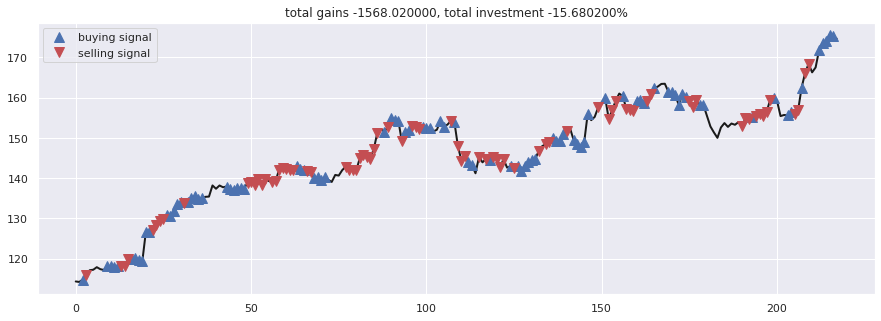

In [12]:
fig = plt.figure(figsize = (15,5))
plt.plot(test_close, color='k', lw=2.)
plt.plot(test_close, '^', markersize=10, color='b', label = 'buying signal', markevery = states_buy)
plt.plot(test_close, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()